In [1]:
#random processes

import torch
import math

class RandomProcess:
    
    def sample():
        raise NotImplementedError

class AnnealedGaussianProcess(RandomProcess):

    def __init__(self, sigma_max, sigma_min=None, n_steps_annealing=1):
        if sigma_min is None: sigma_min = torch.zeros_like(sigma_max)
        self._sigma_max = sigma_max
        self._sigma_min = sigma_min
        self._m = -(sigma_max - sigma_min) / float(n_steps_annealing)
        self._n_steps = 0

    def sample(self):
        self._n_steps += 1
        return self._sigma * torch.randn_like(self._sigma_max)

    @property
    def _sigma(self):
        result = torch.max(self._sigma_min, self._m * float(self._n_steps) + self._sigma_max)
        return result

class OrnsteinUhlenbeckProcess(RandomProcess):

    def __init__(self, theta, sigma_max, n_steps_annealing, dt=1., x0=None, sigma_min=None):
        self._gaussian = AnnealedGaussianProcess(sigma_max=sigma_max, sigma_min=sigma_min, n_steps_annealing=n_steps_annealing)
        self._theta = theta
        self._dt = dt
        if x0 is None: x0 = torch.zeros_like(sigma_max)
        self._x_prev = x0
        self._sqdt = math.sqrt(self._dt)

    def sample(self):
        x = self._x_prev * (1. - self._theta * self._dt) + self._gaussian.sample() * self._sqdt
        self._x_prev = x
        return x

In [2]:
import torch
import copy

class ActorCritic(torch.nn.Module):
#this object encapsulates an actor network and a critic network, and is capable of calculating outputs (actions, values) when provided with an input, as well as optimizing the actor and the critic networks when provided with a necessary input and target values
    
    def __init__(self, actor, critic):
        super(ActorCritic, self).__init__()
        self._actor = actor
        self._critic = critic
        self._nb_states = actor._nb_states
        self._nb_actions = actor._nb_actions
    
    def calc_actions(self, s):
        return self._actor(s)
        
    def calc_qvalues(self, s, a):
        return self._critic(s, a)
    
    def calc_values(self, s):
        return self.calc_qvalues(s, self.calc_actions(s))
    
    def optimize_actor(self, s):
        q = self.calc_values(s)
        loss = -q.mean();
        loss.backward()
        self._actor.optimize()
        self.zero_grad()
    
    def optimize_critic(self, s, a, target):
        loss = torch.nn.functional.mse_loss(self.calc_qvalues(s, a), target, reduction='mean')
        loss.backward()
        self._critic.optimize()
        self._critic.zero_grad()
        
class L4Actor(torch.nn.Module):

    def __init__(self, nb_states, nb_actions, hidden1=128, hidden2=64, init_w=3e-3, optim=torch.optim.Adam,
                 lr=1e-4, l2=0):
        super(L4Actor, self).__init__()
        self._fc1 = torch.nn.Linear(nb_states, hidden1).cuda()
        self._fc2 = torch.nn.Linear(hidden1, hidden2).cuda()
        self._fc3 = torch.nn.Linear(hidden2, nb_actions).cuda()
        self._fc3.weight.data.uniform_(-init_w, init_w)
        self._nb_states=nb_states
        self._nb_actions=nb_actions
        self._optim = optim(self.parameters(), lr=lr, weight_decay=l2)
    
    def forward(self, s):
        a = self._fc1(s)
        a = torch.nn.functional.relu(a)
        a = self._fc2(a)
        a = torch.nn.functional.relu(a)
        a = self._fc3(a)
        a = a.tanh()
        return a
    
    def optimize(self):
        self._optim.step()

class L4Critic(torch.nn.Module):

    def __init__(self, nb_states, nb_actions, hidden1=128, hidden2=64, init_w=3e-3, optim=torch.optim.Adam,
                 lr=1e-3, l2=1e-3):
        super(L4Critic, self).__init__()
        self._fc1 = torch.nn.Linear(nb_states, hidden1).cuda()
        self._fc2 = torch.nn.Linear(hidden1+nb_actions, hidden2).cuda()
        self._fc3 = torch.nn.Linear(hidden2, 1).cuda()
        self._fc3.weight.data.uniform_(-init_w, init_w)
        self._nb_states=nb_states
        self._nb_actions=nb_actions
        self._optim = optim(self.parameters(), lr=lr, weight_decay=l2)
    
    def forward(self, s, a):
        s = self._fc1(s)
        s = torch.nn.functional.relu(s)
        q = self._fc2(torch.cat((s, a), 1))
        q = torch.nn.functional.relu(q)
        q = self._fc3(q)
        return q
    
    def optimize(self):
        self._optim.step()

In [3]:
import copy
import torch

class DDPG:
#this object manages an actor-critic by providing it with inputs for calculating actions and for optimization

    def __init__(self, gamma, random_process, actor_critic, tau):
        self._network = actor_critic
        self._target_network = copy.deepcopy(actor_critic)
        self._nb_states = actor_critic._nb_states
        self._nb_actions = actor_critic._nb_actions
        for target_param in self._target_network.parameters(): target_param.requires_grad_(False)
        self._target_network.eval()
        self._random_process = random_process
        self._gamma = gamma
        self._tau = tau
        self._preprocessor = torch.nn.BatchNorm1d(nb_states, affine=False, momentum=None).cuda()
        self._preprocessor.eval()
        self._preprocessor_samples = int(0)
        self._preprocessor_lock = False

    def _preprocess(self, s):
        return self._preprocessor(s)
        
    def update_preprocessor(self, s):
        if self._preprocessor_lock: return
#default BatchNorm training is not appropriate for the task; we will update the layer parameters manually
        n = self._preprocessor_samples
        if n == 0:
            mu = s
            var = torch.zeros_like(s)
        else:
            mu = self._preprocessor.running_mean
            var = self._preprocessor.running_var
            var = (n / (n + 1)) * (var + (s - mu) ** 2 / (n + 1))
            mu = (n * mu + s) / (n + 1) 
        self._preprocessor.running_mean = mu
        self._preprocessor.running_var = var
        self._preprocessor_samples += 1

    def lock_preprocessor(self):
#once the BatchNorm parameters are good enough, we keep them constant to facilitate learning
        self._preprocessor_lock = True

    def target_policy(self, s):
        training = self._network.training
        self._network.eval()
        with torch.no_grad():
            s = self._preprocess(s[None,:])
            result = self._network.calc_actions(s)[0]
        if training: self._network.train()
        return result
    
    def behavior_policy(self, s):
        return torch.clamp(self._random_process.sample() + self.target_policy(s), -1, 1)
    
    def step(self, s, explore=True):
        self.update_preprocessor(s)
        if explore: return self.behavior_policy(s)
        return self.target_policy(s)
    
    def update_actor(self, sarst):
        s = sarst[:,:self._nb_states]
        s = self._preprocess(s)
        self._network.optimize_actor(s)
            
    def update_critic(self, sarst):
        s1 = sarst[:,:self._nb_states]
        s1 = self._preprocess(s1)
        a = sarst[:,self._nb_states:self._nb_states+self._nb_actions]
        r = sarst[:,self._nb_states+self._nb_actions:self._nb_states+self._nb_actions+1]
        s2 = sarst[:,self._nb_states+self._nb_actions+1:2*self._nb_states+self._nb_actions+1]
        s2 = self._preprocess(s2)
        t = sarst[:,-1:]
        target = r + self._gamma * (1 - t) * self._target_network.calc_values(s2)
        self._network.optimize_critic(s1, a, target)
        for target_param, param in zip(self._target_network.parameters(), self._network.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self._tau) + param.data * self._tau)

In [4]:
import random

class RingBuffer:

    def __init__(self, maxlen):
        super(RingBuffer, self).__init__()
        self._maxlen = maxlen
        self._pivot = int(0)
        self._data = []

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx):
        return self._data[idx]

    def append(self, v):
        if len(self._data) < self._maxlen:
            self._data.append(v)
        else:
            self._data[self._pivot] = v
            self._pivot = int((self._pivot + 1) % self._maxlen)
    
    def draw(self, batch_size):
        return random.sample(self._data, k=batch_size)

In [6]:
import torch, numpy

class EnvWrapper:
#wrapper around a Gym environment. normalizes action space to a unit block, wraps observations to PyTorch tensors. Also adds information about current time step.
    
    def __init__(self, env):
        super(EnvWrapper, self).__init__()
        self._env = env
        self._a_min = env.action_space.low
        self._a_max = env.action_space.high
        self._tmax = env._max_episode_steps
    
    def reset(self):
        return self._add_time(self._env.reset())

    def step(self, a):
        a = (self._a_max + self._a_min) * 0.5 + a.cpu().numpy() * (self._a_max - self._a_min) * 0.5
        s, r, t, _ = self._env.step(a)
        return self._add_time(s),\
           torch.tensor([r], dtype=torch.float, device=torch.device('cuda')),\
           torch.tensor([t], dtype=torch.float, device=torch.device('cuda')), t, r
    
    def render(self):
        self._env.render()
    
    def close(self):
        self._env.close()
    
    def _add_time(self, s):
        return torch.from_numpy(s).float().to(torch.device('cuda'))

In [7]:
#initialize everything. all parameters are in this cell

ENV = 'LunarLanderContinuous-v2'
gamma = 0.98

mem_size = 1e5
pre_explore_episodes = 10
batch_size = 64

ou_theta = 0.15
ou_sigma = 0.3
ou_sigma_min = 0.05
ou_dt = 1.
n_steps_annealing = 1e5

hidden1a = 128
hidden2a = 64
init_wa = 3e-3

hidden1c = 128
hidden2c = 64
init_wc = 3e-3

ratea = 1e-4
ratec = 1e-3
tau = 1e-3

import gym
import torch
import torch.utils.data
import hiddenlayer

env = gym.make(ENV)
nb_states = env.observation_space.shape[0]
nb_actions = env.action_space.shape[0]
env = EnvWrapper(env)
ou_theta = ou_theta * torch.ones(nb_actions, device=torch.device('cuda'))
ou_sigma = ou_sigma * torch.ones(nb_actions, device=torch.device('cuda'))
ou_sigma_min = ou_sigma_min * torch.ones(nb_actions, device=torch.device('cuda'))

memory = RingBuffer(mem_size)

random_process = OrnsteinUhlenbeckProcess(theta=ou_theta, sigma_max=ou_sigma, sigma_min=ou_sigma_min, dt=ou_dt,
                                          n_steps_annealing=n_steps_annealing)
actor = L4Actor(nb_states=nb_states, nb_actions=nb_actions, hidden1=hidden1a, hidden2=hidden2a, init_w=init_wa,
                lr=ratea)
critic = L4Critic(nb_states=nb_states, nb_actions=nb_actions, hidden1=hidden1c, hidden2=hidden2c, init_w=init_wc,
                 lr=ratec)
actor_critic = ActorCritic(actor=actor, critic=critic)
model = DDPG(gamma=gamma, random_process=random_process, actor_critic=actor_critic, tau=tau)

s1 = env.reset()
e = 0
R = 0.
history = hiddenlayer.History()
historyt = hiddenlayer.History()
historyrt = hiddenlayer.History()
canvas = hiddenlayer.Canvas()

RT = RingBuffer(100)

def avg(buffer):
    return sum(buffer._data) / len(buffer._data)

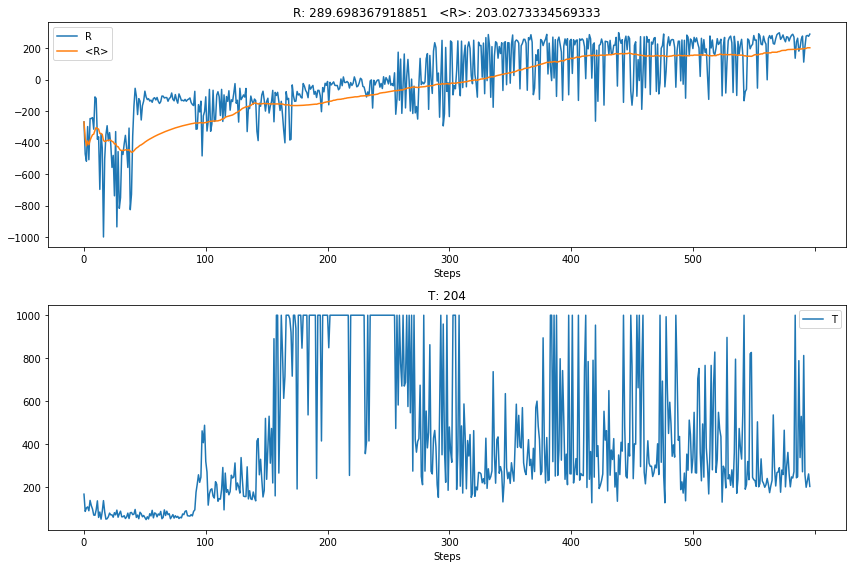

KeyboardInterrupt: 

In [10]:
#this is where all learning takes place

while True:
    a = model.step(s1)
    s2, r, t, term, r_ = env.step(a)
    sarst = torch.cat((s1, a, r, s2, t))
    R += r_
    memory.append(sarst)
    s1 = s2
    if term or env._env._elapsed_steps == env._env._max_episode_steps - 1:
        history.log(e, loss=max(R, -1000))
        historyt.log(e, loss=env._env._elapsed_steps)
        RT.append(R)
        historyrt.log(e, loss=avg(RT))
        with canvas:
            canvas.draw_plot([history["loss"], historyrt["loss"]], labels=["R", "<R>"])
            canvas.draw_plot([historyt["loss"]], labels=["T"])
        s1 = env.reset()
        R = 0
        e += 1
    if e == pre_explore_episodes:
        model.lock_preprocessor
    elif e > pre_explore_episodes:
        x = torch.stack(memory.draw(batch_size))
        model.update_actor(x)
        model.update_critic(x)

In [ ]:
#halt calculations in previous cell and run this one to see how the agent performs with current target policy
import time
env = gym.make(ENV)
env=EnvWrapper(env)
s = env.reset()
term = False
R=0
while not term:
    env.render()
    #time.sleep(0.02)
    a = model.target_policy(s)
    s, r, _, term, _ = env.step(a)
    R+=r

env.close()
print(R)

In [ ]:
#record video
import time
import gym.wrappers

env = gym.make(ENV)
rec =gym.wrappers.Monitor(env, '.', force = True)
env=EnvWrapper(env)

s = env.reset()
term = False

while not term:
    env.render()
    #time.sleep(0.02)
    a = model.target_policy(s)
    s, _, _, term, _ = env.step(a)

rec.close()
env.close()

In [ ]:
#save model
torch.save(model, "model.pt")